# Lab 4: Reading Sign Language with Convolutional Networks
CNNs have revolutionalized basically every problem that takes an image as input, and the simplest of these is image classification.

This project involves using TensorFlow and Keras to build a program that recognizes numbers 0-9 in sign language by classifying images of hands signing those digits.

## Section 0: Download the data
The data is available on Kaggle, at https://www.kaggle.com/ardamavi/sign-language-digits-dataset/.
You'll need an account to download it; let me know if you can't do this.

Make a directory called `data`, then unzip the data files inside that directory.
Your final directory structure should contain files:
 - `.../lab_4_conv_nets/data/X.npy`
 - `.../lab_4_conv_nets/data/Y.npy`

## Section 1: Understand the data
I've taken care of loading the data for you.
Read through the code (especially comments) so you understand what it does, and check out the plots.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
x_all = np.load('data/X.npy')
y_all = np.load('data/Y.npy')

print(x_all.shape)
print(y_all.shape)

(2062, 64, 64)
(2062, 10)


In [3]:
# For whatever reason, the data's labels aren't the actual
# numbers depicted. This box fixes that.
# Real-world data is usually messy; this is one example.

# Maps dataset-provided label to true label
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

# Correct dataset labels
for row in range(y_all.shape[0]):
    dataset_label = np.where(y_all[row])[0][0]
    y_all[row, :] = np.zeros(10)
    y_all[row, label_map[dataset_label]] = 1

In [4]:
# Seed numpy rng for reproducibility
np.random.seed(1337)

# Shuffle features and targets together
# Credit for this technique to:
# https://stackoverflow.com/questions/4601373/
# better-way-to-shuffle-two-numpy-arrays-in-unison
rng_state = np.random.get_state()
np.random.shuffle(x_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

# Add a dummy channel axis to input images
x_all = np.expand_dims(x_all, axis=-1)

# Center and rescale data to the range [-1, 1]
x_all = x_all - 0.5
x_all = x_all * 2

# Create a validation set from 30% of the available data
n_points = x_all.shape[0]
n_test = int(n_points * 0.3)
n_train = n_points - n_test
x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train], axis=0)

In [5]:
# Print important shapes in the dataset
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1444, 64, 64, 1)
x_test shape: (618, 64, 64, 1)
y_train shape: (1444, 10)
y_test shape: (618, 10)


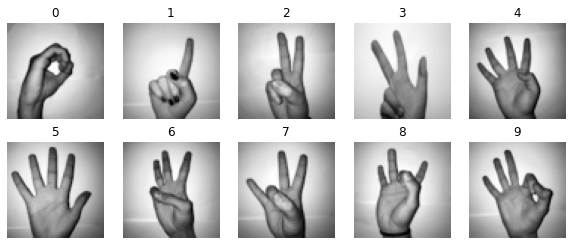

In [6]:
### Plot the first example of each digit in the training set.
### You don't need to understand the code, just look at the output.

# Set up plots
plots = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
axes_list = plots[1].ravel()

for digit in range(10):
    axes = axes_list[digit]
    axes.set_axis_off()
    axes.set_title(digit)
  
    # Find the index of the first appearance of this digit
    idx = np.where(y_train[:, digit] == 1)[0][0]
    
    # Plot the image
    axes.imshow(x_train[idx, :, :, 0],
                cmap='gray')

## Section 2: Build a TensorFlow data pipeline
Set up any `tf.data.Dataset` and `tf.summary.SummaryWriter` objects you need.

I used two `Dataset`s, but there are multiple ways to solve this problem.

In [72]:
num_epochs = 25
batch_size = 64

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size).cache()
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(x_test.shape[0]).batch(batch_size).cache()

train_writer = tf.summary.create_file_writer('./dataset/train')
test_writer = tf.summary.create_file_writer('./dataset/test')

## Section 3: Build a model graph
We'll be building a fairly "traditional" image-processsing CNN: a few layers of 2-D convolutions and max pooling, then flattening, dense layers, and an output layer.

Feel free to experiment with the model architecture.
With a simple network, expect around 90% accuracy.
(Logistic regression gets about 75%).

### 3.1: Class to make dense layers
Copy the `Dense` class you wrote last week here, since this model will need dense layers too.

(In practice, we'd use `tf.layers.Dense`, which does basically the same thing, but using your code from last week gives you more flexibility to do things like plot histograms with minimal extra work).

In [55]:
class Dense(tf.Module):
    '''
    Creates a dense layer module.
    
    Parameters
    ----------
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
        Equivalently, number of units in this layer.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name scopes in this layer.
        Used to simplify visualizations.
    name: string
        Name of layer.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    def __init__(self, dim_input, dim_output, do_activation=True, postfix='', name=None):
        super().__init__(name=name)
        with tf.name_scope('dense' + postfix):
            self.weights = tf.Variable(tf.initializers.he_uniform()(shape = (dim_input, dim_output), dtype = tf.float32), name = 'weights-' + postfix)
            self.bias = tf.Variable(tf.zeros_initializer()(shape = dim_output, dtype = tf.float32), name = 'bias-' + postfix)
            self.do_activation = do_activation
        
    def __call__(self, x):
        output = tf.math.add(tf.matmul(x, self.weights), self.bias)
        if self.do_activation:
            activations = tf.nn.relu(output)
            return activations
        return output

### 3.2: Class to make convolutional layers
Write a `tf.Module` class, similar to `Dense`, called `Conv`, which has its signatures and scopes defined as a stub below.
When called, it should:
 1. Add variables named `filters` and `biases`, of appropriate shapes, to the graph.
 2. Compute the 2-D discrete convolution of `filter` over `input_` using `tf.nn.conv2d`, using the correct filter size and strides, and add in the bias.
 3. If `do_activation`, apply ReLU activation using `tf.nn.relu`.
 4. If `pool_size > 1`, uses `tf.nn.max_pool` to perform max pooling on the width and height axes.
 5. Return the activations if `do_activation`, or the pre-activation otherwise.
 
Hints:
 - Read [the tf.nn.conv2d documentation](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) extensively! It tells you what shapes your variables need to have.
 - The layer will have one kernel per input channel, and one bias per output channel
 - The `conv2d` strides should always be 1 in the batch and channel axes
 - In `max_pool`, the arguments `ksize` and `strides` will be the same
 - `padding` can be either 'SAME' or 'VALID'. I used 'SAME' for `tf.nn.conv2d` operations and 'VALID' for 
   `tf.nn.max_pool` operations.

#### 3.2.1: Compute image
Create a method in your class called `image` that takes in an input. This method will apply the convolution and activation (if applicable) operations, and return the output, but *not* for the pooling operation (which should go in your `__call__` method). This will allow us to visualize the activation maps of various filters throughout training with `tf.summary.image()` by conveniently calling this method.

In [53]:
class Conv(tf.Module):
    '''
    Creates a convolutional layer module.
    
    Parameters
    ----------
    input_channels: int
        Number of channels in the input representation.
    n_filters: int
        Number of channels in the output representation.
        Equivalently, number of filters in this layer.
    filter_size: int
        Width and height of each kernel in the layer's filters.
    stride: int
        Stride to use in the x and y directions for the
        convolution operation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    pool_size: int
        If > 1, does max pooling of this size to the
        width and height axes of the activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
    name: string
        Name of layer
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    def __init__(self, input_channels, n_filters, 
                 filter_size=3, stride=1,
                 do_activation=True, pool_size=1,
                 postfix='', name=None):
        super().__init__(name=name)
        with tf.name_scope('conv' + postfix):
            self.filter_ = tf.Variable(tf.initializers.he_uniform()(shape = (filter_size, filter_size, input_channels, n_filters), dtype = tf.float32), name = 'filter')
            self.bias = tf.Variable(tf.zeros_initializer()(shape = (n_filters), dtype = tf.float32), name = 'bias')
            self.pool_size = pool_size
            self.do_activation = do_activation
            self.stride = stride
            
    def image(self, x):
        pre_activ = tf.nn.conv2d(x, self.filter_, strides = [1, self.stride, self.stride, 1], padding = 'SAME')
        pre_activ = tf.nn.bias_add(pre_activ, self.bias)
        if self.do_activation:
            pre_activ = tf.nn.relu(pre_activ)
        return pre_activ
            
    def __call__(self, x):
        output = self.image(x)
        if self.pool_size > 1:
            output = tf.nn.max_pool(output, ksize = [1, self.pool_size, self.pool_size, 1], strides = [1, self.pool_size, self.pool_size, 1], padding = 'VALID')
        return output

### 3.3: Class to make convolutional neural network
Now for the fun part.
Use `Conv` and `Dense` to make your model, called `ConvNet`.

Hints:
 - Try some layers with convolution and max pooling, then flatten (using `tf.reshape`) and add dense layers
 - The first convolutional layer has 1 input channel
 - The input is 64x64, so do lots of downsampling with strides and max pooling before you switch to dense layers to prevent having a huge number of parameters. (If you don't downsample at all, use 32 filters in the last convolutional layer, and use 128 units in the first dense layer, there will be 64\*64\*32\*128 = ~17 million parameters in that dense layer alone! The whole model should ideally have less than 1 million parameters.)
 - If you're having trouble designing a model, try doing it in Keras first and visualizing the shapes and parameters with `model.summary()`

#### 3.3.1: Compute logits
Use `Dense` to make a final dense layer with `dim_output=10` and no activation to compute the final per-class logits. You'll want to return the logits in a method called `logits` which should take in an input.

#### 3.3.2: Compute class probability for output
Use `tf.nn.softmax` to compute the class probabilities. We will not use this for the loss, just for the output. You'll want to put this in the `__call__` method.

#### 3.3.3: Trace function
Create a decorated trace function so we can visualize the model graph in TensorBoard.

In [83]:
class ConvNet(tf.Module):
    def __init__(self, name=None):
        self.conv1 = Conv(1, 8, filter_size = 5, stride = 1, do_activation = True, pool_size = 1, postfix = 'conv_layer1')
        self.conv2 = Conv(8, 16, filter_size = 5, stride = 1, do_activation = True, pool_size = 1, postfix = 'conv_layer2')
        self.conv3 = Conv(16, 16, filter_size = 5, stride = 1, do_activation = True, pool_size = 2, postfix = 'conv_layer3')
        self.conv4 = Conv(16, 32, filter_size = 3, stride = 1, do_activation = True, pool_size = 1, postfix = 'conv_layer4')
        self.conv5 = Conv(32, 32, filter_size = 3, stride = 1, do_activation = True, pool_size = 1, postfix = 'conv_layer5')
        self.conv6 = Conv(32, 64, filter_size = 3, stride = 1, do_activation = True, pool_size = 2, postfix = 'conv_layer6')
        self.conv7 = Conv(64, 64, filter_size = 3, stride = 1, do_activation = True, pool_size = 2, postfix = 'conv_layer7')
        self.conv8 = Conv(64, 128, filter_size = 3, stride = 1, do_activation = True, pool_size = 2, postfix = 'conv_layer8')
        self.dense1 = Dense(16*128, 512, do_activation = True, postfix = 'dense_layer_1')
        self.dense2 = Dense(512, 128, do_activation = False, postfix = 'dense_layer_2')
        self.dense3 = Dense(128, 10, do_activation = False, postfix = 'dense_layer_2')
        
    def logits(self, x):
        conv_output = self.conv8(self.conv7(self.conv6(self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x))))))))
        # print(conv_output.shape)
        flat = tf.reshape(conv_output, [-1, 16*128])
        out = self.dense3(self.dense2(self.dense1(flat)))
        return out
    
    @tf.function
    def __call__(self, x):
        return tf.nn.softmax(self.logits(x), axis = 1)

### 3.4: Compute cross-entropy loss
Use `tf.nn.softmax_cross_entropy_with_logits()` to compute the per-example loss, then `tf.reduce_mean()` to compute the mean loss for the batch. Put this in a `_loss` method.

In [63]:
def _loss(target, actual):
    loss = tf.nn.softmax_cross_entropy_with_logits(target, actual)
    return tf.reduce_mean(loss)

def accuracy(target, actual):
    target_idx = tf.argmax(target, axis = 1)
    actual_idx = tf.argmax(actual, axis = 1)
    return tf.reduce_mean(tf.cast(tf.math.equal(target_idx, actual_idx),tf.float32))

### 3.5: Optimizer and gradients
Make an optimizer (I used `tf.optimizers.SGD` with `learning_rate=1e-3` and `momentum=0.9`) and update your model. Make a train and test method that each represent an iteration of training. Add a summary operation for loss in both methods.

#### 3.5.1: Predicted digit and per-batch accuracy
The model should predict the digit it assigns the highest probability.
Add a tensor which represents what fraction of the batch the model predicted correctly (its accuracy, or average 0/1 loss), and a summary operation for accuracy in both train and test methods.

Hint: to get the numerical value from the one-hot encoded label, use `tf.argmax`.

#### 3.5.2: Plot images
Add an `image=False` argument to your test method. This will allow us to toggle plotting activation maps on TensorBoard. If `image` is true, create a new 1-channel `tf.summary.image()` for each channel of the activation (pre-pooling). Also, do not plot other summaries when this is the case so as not to skew the loss and accuracy plots with the specific image we will use to plot activation maps. Note that each image needs a channel dimension, though it should be 1 here. 

You will have to use the `image()` method in your `Conv` class to compute the pre-pooled images and plot them. Make sure to supply your convolutional layers with the correct input when plotting these images, e.g. if you're adding a `tf.summary.image` for your third convolutional layer, supply your `image()` method with the post-pooled outputs of the second convolutional layer.

In [77]:
optimizer = tf.optimizers.SGD(1e-3, 0.9)

def train(model, x, y, i):
    with tf.GradientTape() as g:
        loss = _loss(tf.squeeze(y), tf.squeeze(model.logits(x)))
    gradients = g.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    with train_writer.as_default():
        for gradient, variable in zip(gradients, model.trainable_variables):
            if variable.name and gradient is not None:
                tf.summary.histogram('gradients/' + variable.name, tf.norm(gradient), step=i)
                tf.summary.histogram('variables/' + variable.name, tf.norm(variable), step=i)
        tf.summary.scalar('loss', loss, step = i)
        
def test(model, x, y, i, image = False):
    acc = accuracy(y, model(x))
    loss = _loss(y, model(x))
    
    with test_writer.as_default():
        if image:
            img = model.conv1.image(x)
            for i in range(img.shape[3]):
                tf.summary.image('image1_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
            
            img = model.conv2.image(model.conv1(x))
            for i in range(img.shape[3]):
                tf.summary.image('image2_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
            
            img = model.conv3.image(model.conv2(model.conv1(x)))
            for i in range(img.shape[3]):
                tf.summary.image('image3_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
                
            img = model.conv4.image(model.conv3(model.conv2(model.conv1(x))))
            for i in range(img.shape[3]):
                tf.summary.image('image4_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
                
            img = model.conv5.image(model.conv4(model.conv3(model.conv2(model.conv1(x)))))
            for i in range(img.shape[3]):
                tf.summary.image('image5_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
                
            img = model.conv6.image(model.conv5(model.conv4(model.conv3(model.conv2(model.conv1(x))))))
            for i in range(img.shape[3]):
                tf.summary.image('image6_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
                
            img = model.conv7.image(model.conv6(model.conv5(model.conv4(model.conv3(model.conv2(model.conv1(x)))))))
            for i in range(img.shape[3]):
                tf.summary.image('image7_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
                
            img = model.conv8.image(model.conv7(model.conv6(model.conv5(model.conv4(model.conv3(model.conv2(model.conv1(x))))))))
            for i in range(img.shape[3]):
                tf.summary.image('image8_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
                
            img = model.conv9(model.conv8(model.conv7(model.conv6(model.conv5(model.conv4(model.conv3(model.conv2(model.conv1(x)))))))))
            for i in range(img.shape[3]):
                tf.summary.image('image9_{}'.format(i), tf.expand_dims(img[:,:,:,i], axis = -1), step = i)
            
        else:
            tf.summary.scalar('loss', loss, step = i)
            tf.summary.scalar('accuracy', acc, step = i)
    return acc

## Section 4: train the model
Same training loop as always, with one small modification: you don't want `tf.summary.image()` operations every batch because it saves images.
Run the other summary operations every batch.

When plotting images, make sure you feed in a "batch" of a single example (the same one every time). This will let you visualize in the TensorBoard Images tab how the activation maps of various filters on that one example change as the network trains.

In [84]:
model = ConvNet()
train_batch = 0
test_batch = 0

for i in range(num_epochs):
    for x, y in dataset_train:
        if train_batch == 0:
            tf.summary.trace_on(graph=True, profiler=True)
            model(x)
            with train_writer.as_default():
                tf.summary.trace_export(name = 'first training batch', step = 0, profiler_outdir = 'dataset')
        train(model, x, y, train_batch)
        train_batch += 1
        
    print('Epoch: ', i)
    test_acc = []
    for x, y in dataset_test:
        test_acc.append(test(model, x, y, test_batch, image = False))
        # Roughly align test batches with training batches
        test_batch += 1
        
    print('Average Test Set Accuracy: ', np.mean(test_acc))
    
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write('./checkpoints_lecture/model')

Epoch:  0
Average Test Set Accuracy:  0.22686012
Epoch:  1
Average Test Set Accuracy:  0.44188985
Epoch:  2
Average Test Set Accuracy:  0.71837795
Epoch:  3
Average Test Set Accuracy:  0.8200892
Epoch:  4
Average Test Set Accuracy:  0.8318453
Epoch:  5
Average Test Set Accuracy:  0.86316967
Epoch:  6
Average Test Set Accuracy:  0.88348216
Epoch:  7
Average Test Set Accuracy:  0.90223217
Epoch:  8
Average Test Set Accuracy:  0.91941965
Epoch:  9
Average Test Set Accuracy:  0.91473216
Epoch:  10
Average Test Set Accuracy:  0.8928572
Epoch:  11
Average Test Set Accuracy:  0.9006697
Epoch:  12
Average Test Set Accuracy:  0.90223217
Epoch:  13
Average Test Set Accuracy:  0.92105657
Epoch:  14
Average Test Set Accuracy:  0.89918154
Epoch:  15
Average Test Set Accuracy:  0.9093006
Epoch:  16
Average Test Set Accuracy:  0.93586314
Epoch:  17
Average Test Set Accuracy:  0.93824404
Epoch:  18
Average Test Set Accuracy:  0.93043154
Epoch:  19
Average Test Set Accuracy:  0.94367564
Epoch:  20
Aver

'./checkpoints_lecture/model'

## Section 5: visualization
Run TensorBoard, go to the Images tab, and look at how the final activation maps in various layers differ from each other, and (by dragging the slide bar at the top of each) how the activation map of a single filter develops as the network trains.

This is what some activation maps of my first-layer, size-5 convolutions look like:

 **Background**             |  **Edges** 
:-------------------------:|:-------------------------:
![First-layer background activations](./images/background_conv_1.png) | ![First-layer edges activations](./images/edges_conv_1.png)
 **Curvature**              | **Gradients** 
![First-layer curvature activations](./images/curvature_conv_1.png) | ![First-layer gradients activations](./images/gradients_conv_1.png)

I see some interesting results here.
The first and third filters seem to be activating on the background, while the third also appears to activating around the curvature of the hand. The second detects the outside edges of the hand, and the fourth activates for sharp vertical gradients.

Second-layer activation maps are a little more abstract, but still mostly make sense:

 **Background**           | **Edges** 
:-------------------------:|:-------------------------:
![Second-layer background activations](./images/background_conv_2.png) | ![Second-layer edges activations](./images/edges_conv_2.png)
 **Fingers**              | **Complexity** 
![Second-layer fingers activations](./images/fingers_conv_2.png) | ![Second-layer complexity activations](./images/complexity_conv_2.png)

The fourth one is really interesting, it seems to detect areas of high complexity in the image.

My fourth-layer activation maps are too abstract to make any sense of:
![Fourth-layer first activations](./images/first_conv_4.png)
![Fourth-layer second activations](./images/second_conv_4.png)